# #MapYourCity

This notebook showcases the #MapYourCity dataset structure and format. The three modalities are visualised and the distributions according to training labels, countries and cities is shown. We also present the format and evaluation metrics for challenge solution submission.

## Dataset structure

The dataset is divided into 2 collections, train and test. Each collection contains a csv file with a list of labeled building IDs (pid) and a data folder containing up to 3 images for every building (street view, orthophoto and Sentinel 2) and also the label for the training set. 

Dataset structure:

- /dataset
  - /train
    - train-set.csv
    - /data
      - /< pid >
        - label.txt
        - street.jpg
        - s2_l2a.tif
        - orthophoto.tif
  - /test
    - test-set.csv
    - /data
      - /< pid >
        - street.jpg (for 2 cities only)
        - s2_l2a.tif
        - orthophoto.tif

## Image formats and structure

The dataset consists of three different image modalities and the labels for the training set: 
- streetview image in **jpg** format of pixel size 512 x 1024 showing the face-view of the building
  
- top-view orthophoto image in **tif** format of size of 512 x 512 pixels with pixel size of 0.5 m, covering an area of 256 x 256 squared metres around the building, with three bands (RGB)
  
- top-view Sentinel-2 L2A image **tif** format of size 64 x 64 with pixel size of 10 m, covering an area of 640 x 640 squared metres around the building, with 12 bands:
- - [Sentinel-2 L2A bands](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data): ["B01","B02", "B03", "B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
  
- a **txt** file with labels. There are 7 different labels (classes) denoting 7 binned age of buildings. 

The images are loaded and visualised in the sections below.

## Load data

In [74]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

In [75]:
# Define paths to data

# input_path = "directory with MapYourCity image files"
input_path = "dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"

In [76]:
# Load csv files
test_df = pd.read_csv(input_path + "test/test-set.csv")
train_df = pd.read_csv(input_path + "train/train-set.csv")

In [77]:
# Check csv files
train_df.head()

,label,country_id,pid,city_id
0,5,QCD,z5tkosm85q,4VAXW
1,1,QCD,nqblpfzyv6,4VAXW
2,5,QCD,2ume6kkg36,4VAXW
3,1,QCD,e2k9hq8wdy,4VAXW
4,5,QCD,nputhcozta,4VAXW


In [78]:
test_df.head()

,country_id,pid,city_id
0,PNN,eywttujal8,B2MVH
1,PNN,msagwwvcpf,B2MVH
2,PNN,cxywc79dxr,B2MVH
3,PNN,9kfydhmwko,B2MVH
4,PNN,d73djidnac,B2MVH


## Image visualisation

In [79]:
# Choose a building by pid:

pid = "225eklykc3"

street = plt.imread(f"{train_path}{pid}/street.jpg")
orthophoto = plt.imread(f"{train_path}{pid}/orthophoto.tif")
s2 = rasterio.open(f"{train_path}{pid}/s2_l2a.tif").read()
s2 = np.transpose(s2,[1,2,0])

print("Image dimensions:")
print(f"street view: {street.shape}" )
print(f"orthophoto: {orthophoto.shape}" )
print(f"Sentinel 2: {s2.shape}" )



Image dimensions:
street view: (512, 1024, 3)
orthophoto: (512, 512, 3)
Sentinel 2: (64, 64, 12)


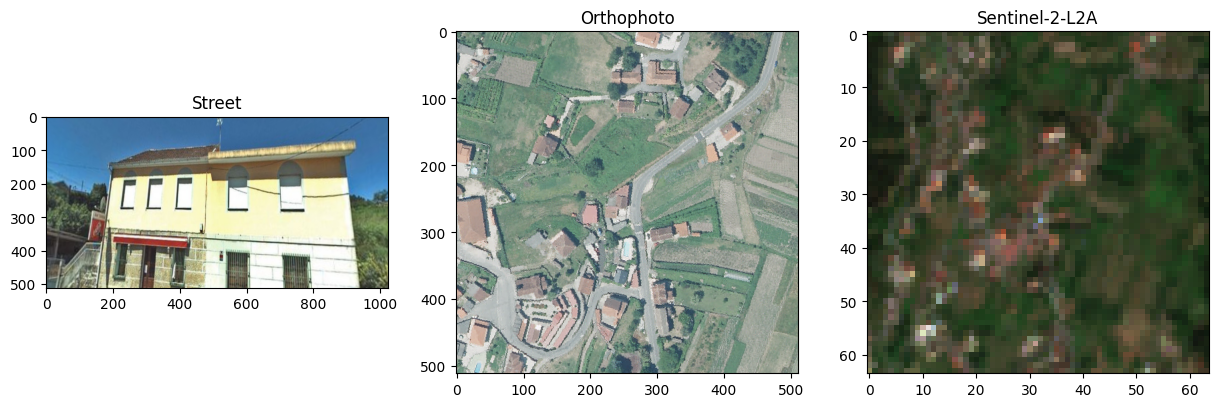

In [80]:
# Show the 3 modalities - street view, orthophoto and Seninel-2

fig, axs = plt.subplots(figsize=(15, 15), ncols = 3)
axs[0].imshow(street)
axs[1].imshow(orthophoto)
axs[2].imshow(s2[...,[3,2,1]]*3e-4)

axs[0].set_title("Street")
axs[1].set_title("Orthophoto")
axs[2].set_title("Sentinel-2-L2A");

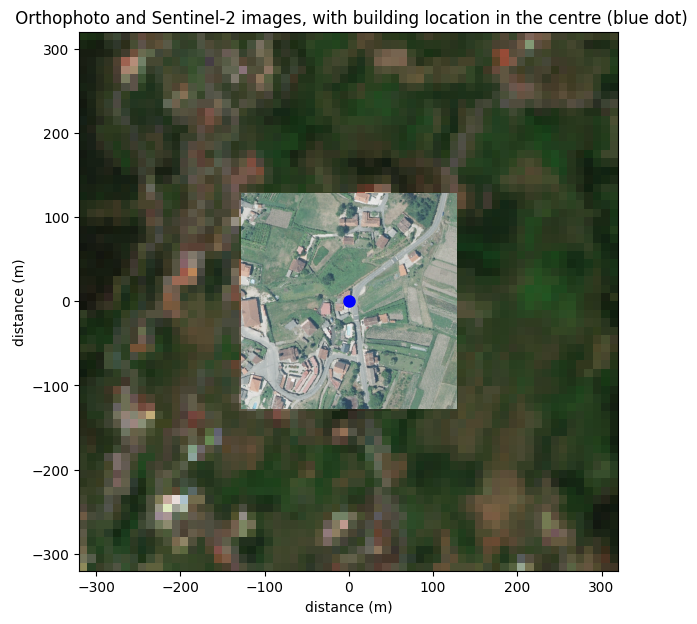

In [81]:
# Relative position and size of orthophoto and Sentinel-2 images, with building location (blue dot)

plt.figure(figsize=(7,7))
plt.imshow(s2[...,[3,2,1]]*3e-4, extent=(-320, 320, -320, 320))
plt.imshow(orthophoto, extent=(-128, 128, -128, 128))
plt.plot(0,0, "b", marker = "o", markersize = 8 ) # building location
plt.title(" Orthophoto and Sentinel-2 images, with building location in the centre (blue dot)")
plt.xlabel("distance (m)")
plt.ylabel("distance (m)")
plt.plot();


## Data exploration

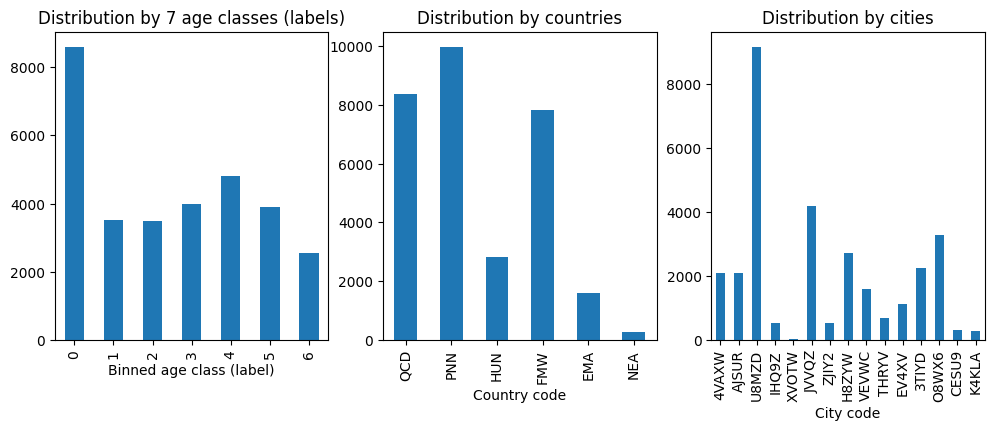

In [82]:
# Plot the distribution by age classes(labels), countries and cities

fig, axs = plt.subplots(figsize=(12, 4), ncols=3)
train_df["label"].value_counts(sort=False).sort_index().plot(kind="bar", ax = axs[0])
train_df["country_id"].value_counts(sort=False).plot(kind="bar", ax = axs[1])
train_df["city_id"].value_counts(sort=False).plot(kind="bar",ax = axs[2])

axs[0].set_title("Distribution by 7 age classes (labels)")
axs[0].set_xlabel("Binned age class (label)")
axs[1].set_title("Distribution by countries")
axs[1].set_xlabel("Country code")
axs[2].set_title("Distribution by cities")
axs[2].set_xlabel("City code");


# Submission format

To submit your solution, create a csv file with building IDs (pid) and corresponding result labels (as shown in dummy example below), created by running your trained model on the test dataset.

In [84]:

res_df = test_df.copy()
res_df["predicted_label"]= np.random.randint(0,6,res_df.shape[0])
res_df.head()


,country_id,pid,city_id,predicted_label
0,PNN,eywttujal8,B2MVH,1
1,PNN,msagwwvcpf,B2MVH,1
2,PNN,cxywc79dxr,B2MVH,1
3,PNN,9kfydhmwko,B2MVH,1
4,PNN,d73djidnac,B2MVH,3


In [85]:
# save solution to csv
res_df.to_csv("example_result.csv")

# Evaluation metrics

Solutions will be evaluated according to the [Mean Producer Accuracy](https://pages.cms.hu-berlin.de/EOL/geo_rs/S09_Accuracy_assessment.html) (MPA: the average of diagonal elements of the 7-class confusion matrix) according to:

### (1/2) MPA {all_modalities} + (1/2) MPA {top_view_modalities} 

The above scoring metric aims to give a boost to solutions with inference on only 2 (top view) modalities.  